In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import sys, os
from os.path import join, dirname
main_dir = dirname(os.getcwd())
sys.path.append(main_dir)

In [3]:
import numpy as np
from time import time
import matplotlib.pyplot as plt # type: ignore
import casadi as ca # type: ignore
import si4kalman
rng = np.random.default_rng(seed=0)

In [4]:
def diff(x1, x2):
    return np.sum((x1-x2)**2)

# Problem definition

In [5]:
Ntrain = 3000

nx = 5
measurements = [2, 5]
q = 1e-6
qu = None
os = True

model_true = si4kalman.condconv_model(
    nx=nx, measurements=measurements, qu=qu, q=q, os=os, min_beta=1e-2)
model = si4kalman.condconv_model(
    nx=nx, measurements=measurements, qu=qu, q=q, os=os, min_beta=1e-2)

x0 = np.zeros(model_true.nx)
P0 = np.eye(model_true.nx) * 0.


# Data generation 

In [6]:
def make_u(N, u1, u2, step_len):
    us = np.empty((N, u1.shape[0]))
    idx = 1
    for i in range(N):
        if idx == 1:
            us[i] = u1
        else:
            us[i] = u2
        if i % step_len == 0:
            idx = 3 - idx
    return us

In [7]:
u1 = np.array([200., 1.])
u2 = np.array([100., 0.])
step_len = 200

us_train = make_u(Ntrain, u1, u2, step_len)

In [8]:
# noise in the true data
alpha_true, beta_true = model_true.draw(rng) # choose a "true parameter randomly"

<IPython.core.display.Javascript object>


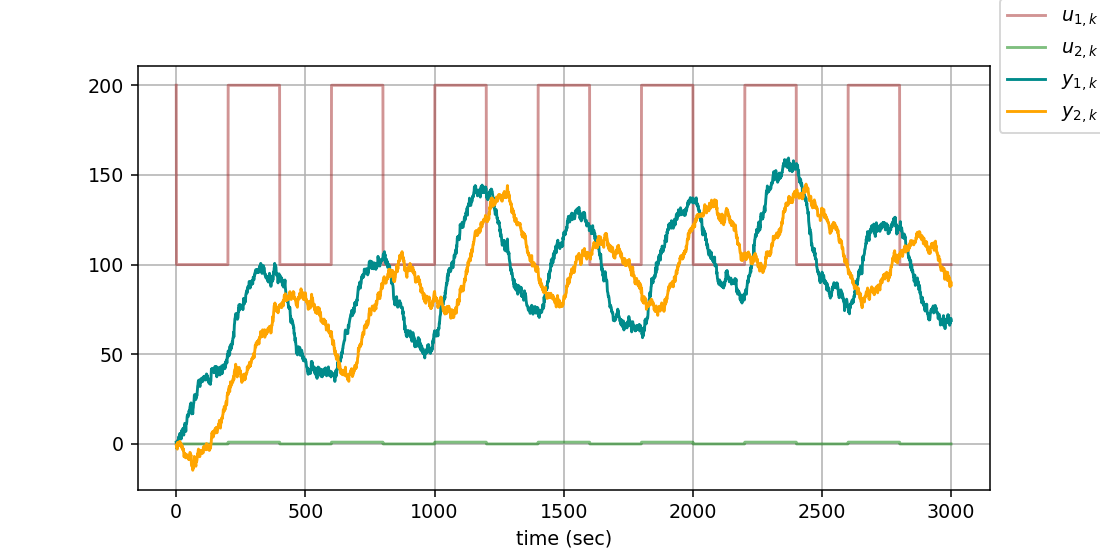

In [9]:
ys_train, _ = model_true.simulation(x0, us_train, alpha_true,  beta_true, rng)

assert model_true.feasible(alpha_true, beta_true), "Constraints should be satisfied for the true parameters"
fig = si4kalman.plot_data(us_train, ys_train, alpha_u=0.5)

# Estimation

In [10]:
alpha_true, beta_true

(array([0.63696169, 0.26978671, 0.04097352]),
 array([0.01652764, 0.81327024, 0.91275558, 0.60663578]))

In [11]:
problemTrain = si4kalman.ProblemParser(
    model, ys_train, us_train, x0, P0, lti=False)

In [12]:
opts = {"pen_step":1e-4, "maxiter":20, "tol.direction":0., "tol.kkt":1e-8}

In [13]:
Ns = [200, 500, 1000, 1500]

In [14]:
## Optimize over the Kalman filter
res = {}

alpha0 = np.ones(model.nalpha) * 0.5
beta0 = np.ones(model.nbeta) * 0.5
for formulation in ["ExactIPOPT", "ExactSQP"]:
    infos = {}
    for N in Ns:
        print("Formulation : {}, N = {}".format(formulation, N))
        problemTrain.cut(N)
        t0 = time()
        alpha, beta, stats = problemTrain.solve(alpha0, beta0, formulation, opts, verbose=False, rescale=False)
        rtime = time() - t0
        error_alpha = diff(alpha, alpha_true)
        error_beta = diff(beta, beta_true)
        error = error_alpha + error_beta
        if formulation[-3:] == "SQP":
            niter = stats['niter']
        else:
            niter = 1
        info = {
                "rtime": rtime,
                "status":stats["return_status"],
                "rtime-per-iter": rtime/niter,
                "alpha": alpha.copy(),
                "beta": beta.copy(),
                "alpha_true": alpha_true.copy(),
                "beta_true": beta_true.copy(),
                "error": error,
                "error_alpha":error_alpha,
                "error_beta":error_beta
            }
        infos[N] = info
        print("rtime : {:.2e}  status : {}".format(rtime, stats["return_status"]))
        
        alpha0 = alpha.copy() # for making faster, to remove
        beta0 = beta.copy()
        
    res[formulation] = infos

Formulation : ExactIPOPT, N = 200
rtime : 3.92e+00  status : Solve_Succeeded
Formulation : ExactIPOPT, N = 500
rtime : 1.17e+01  status : Solve_Succeeded
Formulation : ExactIPOPT, N = 1000
rtime : 2.99e+01  status : Solve_Succeeded
Formulation : ExactIPOPT, N = 1500
rtime : 6.99e+01  status : Solve_Succeeded
Formulation : ExactSQP, N = 200
rtime : 9.29e-01  status : rtol.cost_decrease
Formulation : ExactSQP, N = 500
rtime : 4.14e+00  status : rtol.cost_decrease
Formulation : ExactSQP, N = 1000
rtime : 4.49e+00  status : rtol.cost_decrease
Formulation : ExactSQP, N = 1500
rtime : 6.08e+00  status : rtol.cost_decrease


In [15]:
for formulation, infos in res.items():
    print("solution for", formulation)
    for N, info in infos.items():
        print("N = {}".format(N))
        print("Running time : {:.2e}".format(info["rtime"]))
        print("Error : {:.2e}".format(info["error"]))
        print("Status : {}".format(info["status"]))
        print("beta_true : {}".format(info["beta_true"]))
        print("beta : {}".format(info["beta"]))
        print("alpha_true : {}".format(info["alpha_true"]))
        print("alpha : {}".format(info["alpha"]))

        print(" ")
    print(" ")

solution for ExactIPOPT
N = 200
Running time : 3.92e+00
Error : 3.83e-02
Status : Solve_Succeeded
beta_true : [0.01652764 0.81327024 0.91275558 0.60663578]
beta : [0.00999999 0.97155014 0.92275736 0.49609005]
alpha_true : [0.63696169 0.26978671 0.04097352]
alpha : [0.63658157 0.27263982 0.011438  ]
 
N = 500
Running time : 1.17e+01
Error : 2.83e-02
Status : Solve_Succeeded
beta_true : [0.01652764 0.81327024 0.91275558 0.60663578]
beta : [0.00999999 0.92359047 0.85434192 0.49427265]
alpha_true : [0.63696169 0.26978671 0.04097352]
alpha : [0.63587758 0.27224148 0.03686893]
 
N = 1000
Running time : 2.99e+01
Error : 3.00e-02
Status : Solve_Succeeded
beta_true : [0.01652764 0.81327024 0.91275558 0.60663578]
beta : [0.00999999 0.92731993 0.80721273 0.53040853]
alpha_true : [0.63696169 0.26978671 0.04097352]
alpha : [0.63645111 0.27114666 0.04007898]
 
N = 1500
Running time : 6.99e+01
Error : 1.22e-02
Status : Solve_Succeeded
beta_true : [0.01652764 0.81327024 0.91275558 0.60663578]
beta : [

<IPython.core.display.Javascript object>


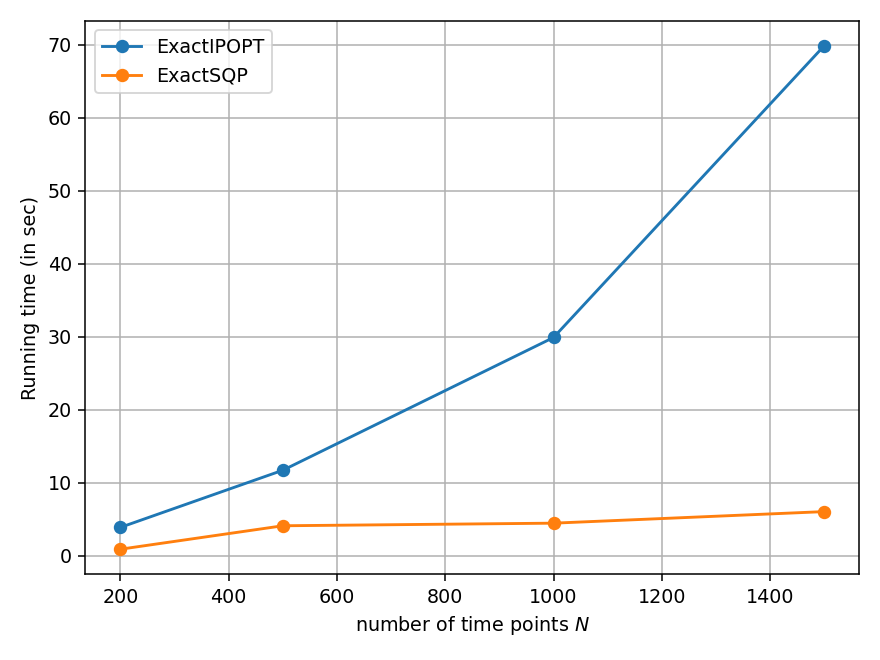

In [16]:
fig = si4kalman.plot_res(res, "rtime", scale="lin")

<IPython.core.display.Javascript object>


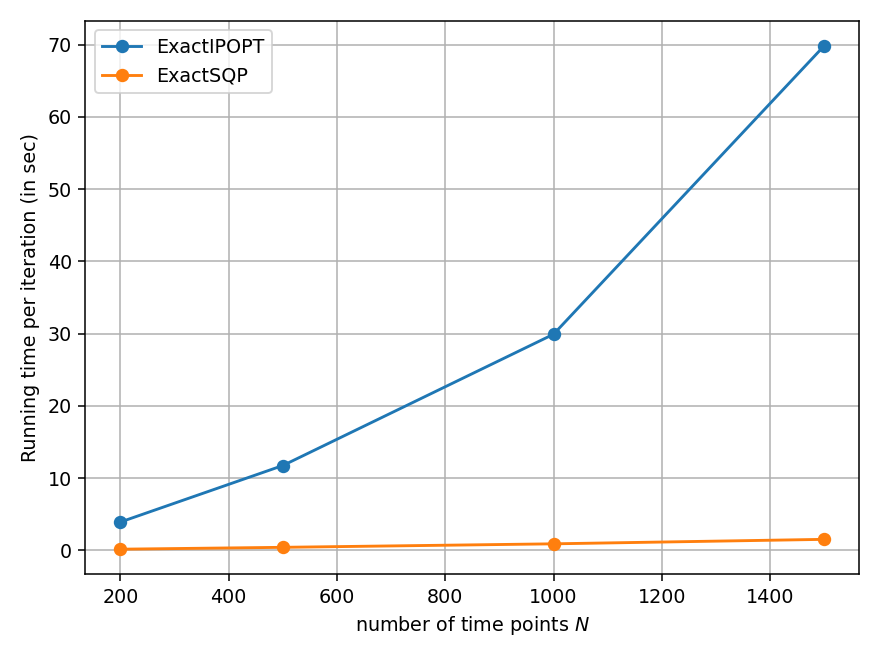

In [17]:
fig = si4kalman.plot_res(res, "rtime-per-iter", scale="lin")

<IPython.core.display.Javascript object>


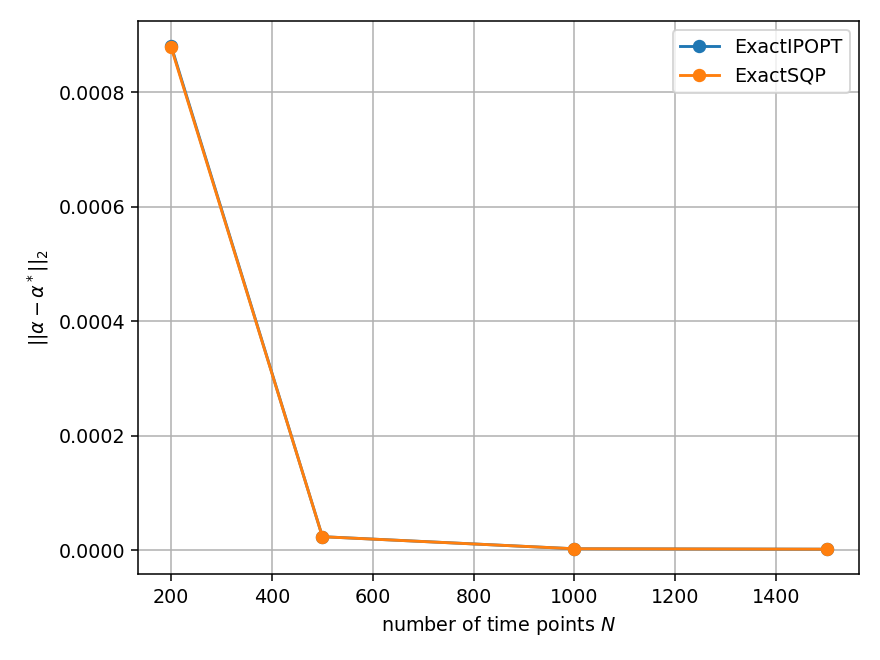

In [18]:
fig = si4kalman.plot_res(res, "error_alpha")

<IPython.core.display.Javascript object>


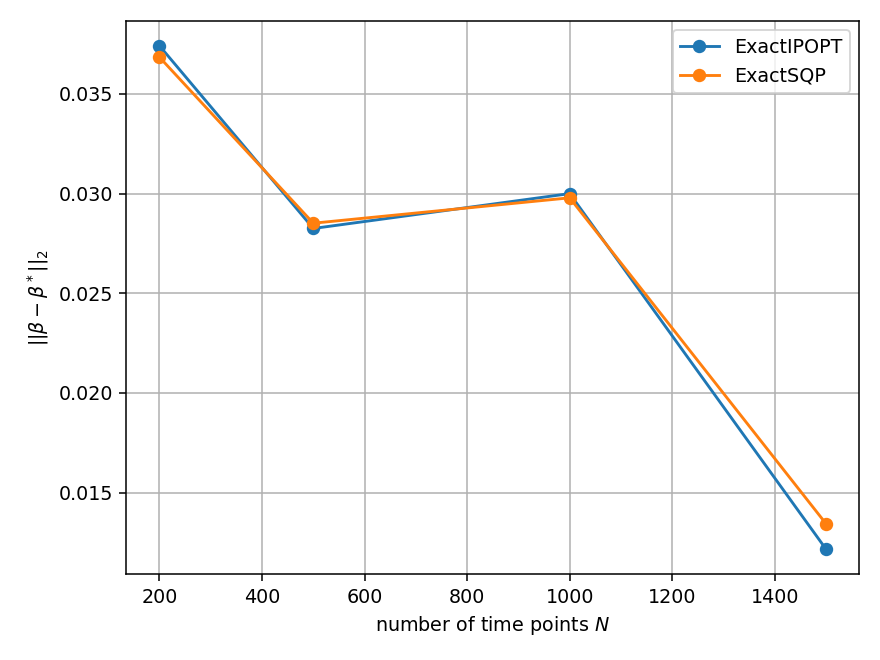

In [19]:
fig = si4kalman.plot_res(res, "error_beta")